# Try out the GSMT simulator

In [1]:
# try it out
import numpy as np
import matplotlib.pyplot as plt
# windows only
# import zosapi
# zos = zosapi.App()
import gsmt
from gsmt import (
    sim_params,
    filters,
    tmt_conf,
    elt_conf,
    gmt_conf,
    sim_gsmt_jones_pupil,
    create_elt_aperture_and_phase,
    create_tmt_aperture_and_phase
)
from hcipy import *
from importlib import reload

# I think the surfaces are wrong

In [2]:
sim_params['wavelength'] = filters['I'] * 1e-6
sim_params['order'] = 2
sim_params['npix_pupil'] = 1024
sim_params['segment variation'] = False
sim_params['poke.Rayfront'] = 'rayfronts/ELT.msgpack'

wfout = sim_gsmt_jones_pupil(sim_params, elt_conf)

sim_params['segment variation'] = True
wfout_aberrated = sim_gsmt_jones_pupil(sim_params, elt_conf)

<ipython-input-4-1daead3563f8>:4: RuntimeWarning: invalid value encountered in divide
  imshow_field((wfin_aberrated.phase[1,1] - wfin.phase[1,1]) / ap.ravel())


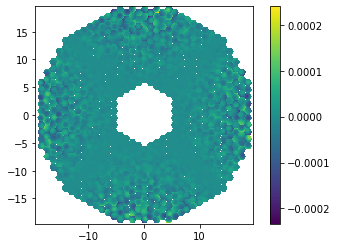

In [4]:
# ap,phs = create_elt_aperture_and_phase(rand_seed=0)
# # plt.imshow(phs.reshape([1024,1024]) / np.max(phs) * tmt_conf['nominal thickness'])
# # plt.colorbar()
# imshow_field((wfin_aberrated.phase[1,1] - wfin.phase[1,1]) / ap.ravel())
# plt.colorbar()

In [5]:
# print(np.sum(wfout.power))
# print(np.sum(wfout_aberrated.power))

0.023645371766513712
0.023642199923636666


In [3]:
# from matplotlib.colors import SymLogNorm
# normdef = SymLogNorm(vmin=-1e-7,vmax=1e-7,linthresh=1e-10)
# plt.figure(figsize=[20,5])
# plt.subplot(131)
# plt.title('Nominal')
# imshow_field(np.log10(wfout.power),vmin=-10,vmax=-4)
# plt.colorbar()
# plt.subplot(132)
# plt.title('Aberrated')
# imshow_field(np.log10(wfout_aberrated.power),vmin=-10,vmax=-4)
# plt.colorbar()
# plt.subplot(133)
# plt.title('Difference')
# imshow_field(wfout.power - wfout_aberrated.power,cmap='RdBu_r', norm=normdef)
# plt.colorbar()
# plt.show()

In [4]:
# try a whole data cyoob
side = 150
residual_cube = np.zeros([25,150,150])
print(residual_cube.shape)

(25, 150, 150)


In [5]:
def str_to_int(string):
    a = string.encode()
    a = int.from_bytes(a,'little')
    return a

str_to_int('mauka')

418414682477

In [9]:
case1 = np.load('25trials_order2_TMT_Iband_primaryvar_10pct.npy')
case2 = np.load('25trials_order2_TMT_Iband_primaryvar_50pct.npy')

plt.figure(figsize=[10,5])
plt.subplot(121)
plt.imshow((case1[0]))
plt.colorbar()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '25trials_order2_TMT_Iband_primaryvar_10pct.npy'

In [6]:
# Generates a bunch or random cases
randseeds = ['ohana','mahalo','aloha','makai','mauka',
             'uamau','keeao','kaaina','ika','pono',
             'mauna','keiki','kokua','lanai','kauai',
             'akamai','olelo','iiwi','hee','kupuna',
             'hoku','honu ','hula','kaolo','kane']

for o in [2,4,6]:
    for pct in [0.1,0.2,0.5]:
        for i,rand in enumerate(randseeds):
            reload(gsmt)
            from gsmt import sim_params, gmt_conf, tmt_conf, elt_conf
            sim_params['wavelength'] = filters['I'] * 1e-6
            sim_params['order'] = o
            sim_params['npix_pupil'] = 1024
            sim_params['segment variation'] = True
            sim_params['random seed'] = int(str_to_int(rand) / 1e5)
            
            # parts that change v.s. telescope
            sim_params['poke.Rayfront'] = 'rayfronts/ELT.msgpack'
            tele_conf = elt_conf
            # gmt_conf['n'] = indx
            tele_conf['aberration ptv'] = pct

            residual_cube[i] = sim_gsmt_jones_pupil(sim_params, tele_conf=tele_conf).power.shaped
        
        np.save(f'25trials_order{o}_ELT_Iband_primaryvar_{int(pct*100)}pct.npy',residual_cube)

In [12]:
mean_trials = np.mean(residual_cube,axis=0)

In [22]:
plt.imshow(wfout.power.shaped - residual_cube[0],cmap='RdBu_r')

NameError: name 'wfout' is not defined

<ipython-input-15-8bd7afe5d589>:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(residual_cube[0]),cmap='RdBu_r',vmin=-10)


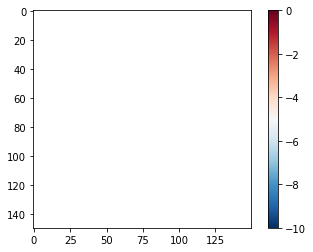

In [15]:
std_trials = np.std(residual_cube,axis=0)
mean_trials = np.mean(residual_cube,axis=0)
plt.imshow(np.log10(residual_cube[0]),cmap='RdBu_r',vmin=-10)
plt.colorbar()

In [35]:
# np.save('25trials_order6_ELT_Iband_primaryvar.npy',residual_cube)

In [13]:
def reg_radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

case_pct = [10,20,50]
case_ind = [1,2,3]

tmt_pro_2 = []
tmt_pro_4 = []
tmt_pro_6 = []

elt_pro_2 = []
elt_pro_4 = []
elt_pro_6 = []

gmt_pro_2 = []
gmt_pro_4 = []
gmt_pro_6 = []

for pct,ind in zip(case_pct,case_ind):

    # load up the profiles
    tmt_cube_o2 = np.load(f'25trials_order2_TMT_Iband_primaryvar_{pct}pct.npy')
    elt_cube_o2 = np.load(f'25trials_order2_ELT_Iband_primaryvar_{pct}pct.npy')
    gmt_cube_o2 = np.load(f'25trials_order2_GMT_Iband_primaryvar_2pct_indx{ind}.npy')

    tmt_cube_o4 = np.load(f'25trials_order4_TMT_Iband_primaryvar_{pct}pct.npy')
    elt_cube_o4 = np.load(f'25trials_order4_ELT_Iband_primaryvar_{pct}pct.npy')
    gmt_cube_o4 = np.load(f'25trials_order4_GMT_Iband_primaryvar_2pct_indx{ind}.npy')

    tmt_cube_o6 = np.load(f'25trials_order6_TMT_Iband_primaryvar_{pct}pct.npy')
    elt_cube_o6 = np.load(f'25trials_order6_ELT_Iband_primaryvar_{pct}pct.npy')
    gmt_cube_o6 = np.load(f'25trials_order6_GMT_Iband_primaryvar_2pct_indx{ind}.npy')

    rad_tmt_2 = reg_radial_profile(np.std(tmt_cube_o2,axis=0),[mean_trials.shape[0]/2,mean_trials.shape[0]/2])
    rad_elt_2 = reg_radial_profile(np.std(elt_cube_o2,axis=0),[mean_trials.shape[0]/2,mean_trials.shape[0]/2])
    rad_gmt_2 = reg_radial_profile(np.std(gmt_cube_o2,axis=0),[mean_trials.shape[0]/2,mean_trials.shape[0]/2])

    rad_tmt_4 = reg_radial_profile(np.std(tmt_cube_o4,axis=0),[mean_trials.shape[0]/2,mean_trials.shape[0]/2])
    rad_elt_4 = reg_radial_profile(np.std(elt_cube_o4,axis=0),[mean_trials.shape[0]/2,mean_trials.shape[0]/2])
    rad_gmt_4 = reg_radial_profile(np.std(gmt_cube_o4,axis=0),[mean_trials.shape[0]/2,mean_trials.shape[0]/2])

    rad_tmt_6 = reg_radial_profile(np.std(tmt_cube_o6,axis=0),[mean_trials.shape[0]/2,mean_trials.shape[0]/2])
    rad_elt_6 = reg_radial_profile(np.std(elt_cube_o6,axis=0),[mean_trials.shape[0]/2,mean_trials.shape[0]/2])
    rad_gmt_6 = reg_radial_profile(np.std(gmt_cube_o6,axis=0),[mean_trials.shape[0]/2,mean_trials.shape[0]/2])

    tmt_pro_2.append(rad_tmt_2)
    tmt_pro_4.append(rad_tmt_4)
    tmt_pro_6.append(rad_tmt_6)

    elt_pro_2.append(rad_elt_2)
    elt_pro_4.append(rad_elt_4)
    elt_pro_6.append(rad_elt_6)

    gmt_pro_2.append(rad_gmt_2)
    gmt_pro_4.append(rad_gmt_4)
    gmt_pro_6.append(rad_gmt_6)

<ipython-input-13-32fb3dbf5749>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r = r.astype(np.int)


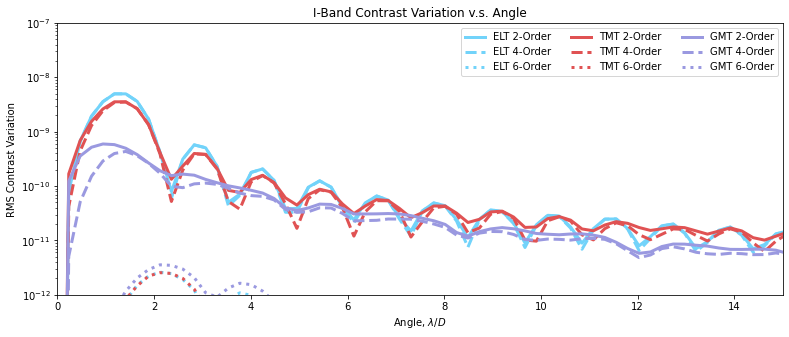

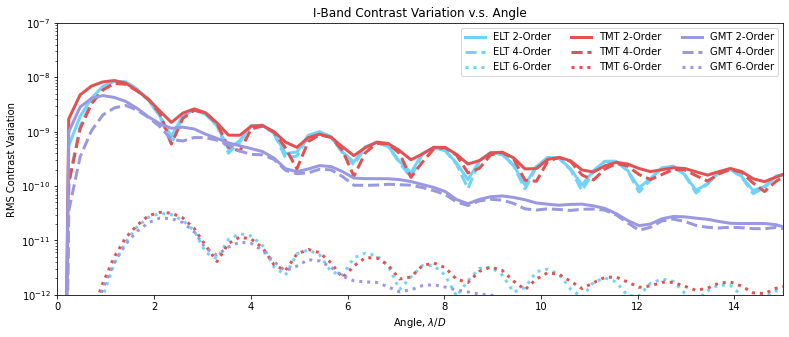

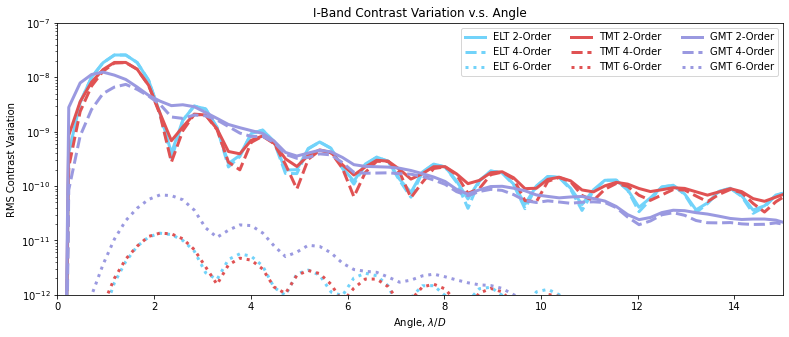

In [15]:
dx_ld = 1/sim_params['q_focal']
eltcolor = '#72d3fa'
tmtcolor = '#e05253'
gmtcolor = '#9a99e0'
lw = 3

xaxis = np.linspace(0,sim_params['nairy_focal'],len(rad_tmt_2))

for i in range(3):

    # plt.plot(rad + rad_std)
    plt.figure(figsize=[13,5])
    plt.title('I-Band Contrast Variation v.s. Angle')
    # plt.subplot(131)
    plt.plot(xaxis,elt_pro_2[i],label='ELT 2-Order',color=eltcolor,linestyle='solid',linewidth=lw)
    plt.plot(xaxis,elt_pro_4[i],label='ELT 4-Order',color=eltcolor,linestyle='dashed',linewidth=lw)
    plt.plot(xaxis,elt_pro_6[i],label='ELT 6-Order',color=eltcolor,linestyle='dotted',linewidth=lw)
    # plt.legend()
    # plt.ylim(1e-10,1e-8)
    # plt.yscale('log')
    # plt.subplot(132)
    plt.plot(xaxis,tmt_pro_2[i],label='TMT 2-Order',color=tmtcolor,linestyle='solid',linewidth=lw)
    plt.plot(xaxis,tmt_pro_4[i],label='TMT 4-Order',color=tmtcolor,linestyle='dashed',linewidth=lw)
    plt.plot(xaxis,tmt_pro_6[i],label='TMT 6-Order',color=tmtcolor,linestyle='dotted',linewidth=lw)
    # plt.legend()
    # plt.ylim(1e-10,1e-8)
    # plt.yscale('log')
    # plt.subplot(133)
    plt.plot(xaxis,gmt_pro_2[i],label='GMT 2-Order',color=gmtcolor,linestyle='solid',linewidth=lw)
    plt.plot(xaxis,gmt_pro_4[i],label='GMT 4-Order',color=gmtcolor,linestyle='dashed',linewidth=lw)
    plt.plot(xaxis,gmt_pro_6[i],label='GMT 6-Order',color=gmtcolor,linestyle='dotted',linewidth=lw)
    plt.yscale('log')
    plt.legend(ncol=3)
    plt.ylim(1e-12,1e-7)
    plt.xlim(0,15)
    plt.ylabel('RMS Contrast Variation')
    plt.xlabel('Angle, '+r'$\lambda / D$')
    plt.show()

In [16]:
# Try show a bunch using tmt_cube_02
rad_pro_tmt_2 = []
for im in tmt_cube_o2:
    pro = reg_radial_profile(im, [mean_trials.shape[0]/2,mean_trials.shape[0]/2])
    rad_pro_tmt_2.append(pro)
nom_pro = reg_radial_profile(wfout.power.shaped, [mean_trials.shape[0]/2,mean_trials.shape[0]/2])

<ipython-input-13-32fb3dbf5749>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r = r.astype(np.int)


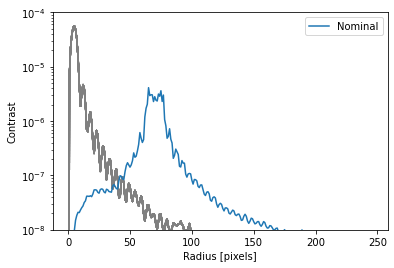

In [17]:
plt.figure()
plt.plot(np.transpose(rad_pro_tmt_2), color='gray')
plt.plot(nom_pro, label='Nominal')
plt.yscale('log')
plt.ylim(1e-8, 1e-4)
plt.ylabel('Contrast')
plt.xlabel('Radius [pixels]')
plt.legend()

In [20]:
from matplotlib.colors import SymLogNorm
plt.figure()
plt.imshow(im - wfout.power.reshape([250,250]), norm=SymLogNorm(linthresh=1e-8),cmap='RdBu_r')
plt.colorbar(label='Normalized Intensity')

ValueError: operands could not be broadcast together with shapes (150,150) (250,250) 

<Figure size 432x288 with 0 Axes>

In [19]:
wfout.power.shaped.shape

(250, 250)

In [44]:
np.sum(im)

0.012281057457391189

In [45]:
np.sum(wfout.power)

Field(0.02364537)